In [4]:
# Define Constants and imports
import os
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import src
from importlib import reload
import traintracker

reload(src)


raw_dataset_dir = "../dataset/raw"
prep_dataset_dir = "../dataset/preprocessed"
train_data_dir="../train_tracker/sentiment_analysis"
weights_dir="../model_weights/sentiment_analysis"
skip_gram_weights="../model_weights/skipgram"

# Introduction
- this notebook will cover sentiment analysis of movie reviews using recurrent neural networks using first Skip-grams model to extract words embeddings for the words that appear in the reviews and then using this word embedding as the first layer for the RNN to give a vector representation for each word
- the model will take the whole review as input and decide if it's a positive review or negative review
- data preprocessing done first at the Skip-grams model training

**Sections**
1. load and view the dataset
2. split the dataset and create dataset train loader
3. create the RNN model with embedding layer from trained skip-gram model
4. model training
5. evaluation and infrences


# Load view Dataset
1. load reviews and labels text file , reviews and labels are line separated
2. collect some statistics about reviews lengths to decide a fixed length for a review

In [2]:
os.listdir(prep_dataset_dir)

['labels.txt',
 'reviews.txt',
 'sentiment_analysis',
 'skipgram',
 'word2int.json']

In [3]:
with open(os.path.join(prep_dataset_dir, 'reviews.txt'), 'r') as rev_file:
    prep_reviews_txt = rev_file.read()
with open(os.path.join(prep_dataset_dir, 'labels.txt'), 'r') as labels_file:
    prep_labels_txt = labels_file.read()

In [4]:
prep_reviews_txt[:250]

'grew up b 1965 watching loving thunderbirds my mates school watched we played thunderbirds before school during lunch after school we wanted virgil scott no wanted alan counting down 5 became art form took my children see movie hoping would get glimp'

In [5]:
# split('\n')[:-1] to ignore the last empty line
reviews_list = prep_reviews_txt.split('\n')
labels_list = prep_labels_txt.split('\n')

In [6]:
print(f"no of reviews {len(reviews_list)}")

print(f"no of labels {len(labels_list)}")

no of reviews 40000
no of labels 40000


-

In [7]:
reviews_count_list = []
words_counter = Counter(prep_reviews_txt.split())

for review in reviews_list:
    reviews_count_list.append([len(review)])

reviews_cnt_df = pd.DataFrame(reviews_count_list, columns=['review length']).sort_values(ascending=False,
                                                                                         by=['review length'])
words_cnt_df = pd.DataFrame(words_counter.items(), columns=['word', 'word count']).sort_values(ascending=False,
                                                                                               by=['word count'])

## reviews lengths
- knowing the mean of the review lenghth to make it fixed for trainning to be the sequence length for the RNN 
- after knowing the good fixed length for a review long reviews will be cut from right and short reviews will be padded with zeros from the left

In [8]:
# get 100 from top and 100 from mid and 100 from tail
src.data_preprocessing.get_head_mid_tail(reviews_cnt_df,100)

,review length
6378,8796
34167,8129
32922,7455
5878,6701
27424,6481
...,...
28914,38
32386,28
36009,23
26067,23


In [9]:
reviews_cnt_df.describe()

,review length
count,40000.000000
mean,843.247250
std,638.089633
min,18.000000
25%,451.000000
50%,625.000000
75%,1028.250000
max,8796.000000


In [10]:
reviews_cnt_df.median()

review length    625.0
dtype: float64

array([[<AxesSubplot:title={'center':'review length'}>]], dtype=object)

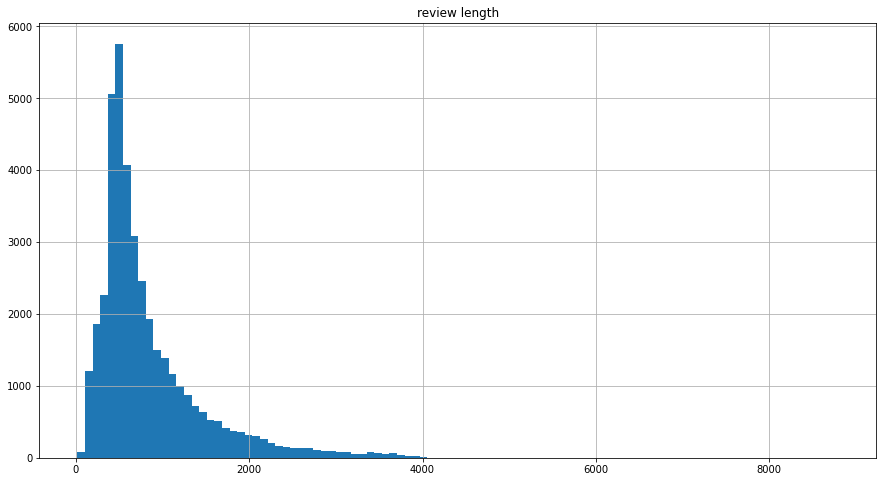

In [11]:
reviews_cnt_df.hist(bins=100, figsize=(15, 8))

array([[<AxesSubplot:title={'center':'review length'}>]], dtype=object)

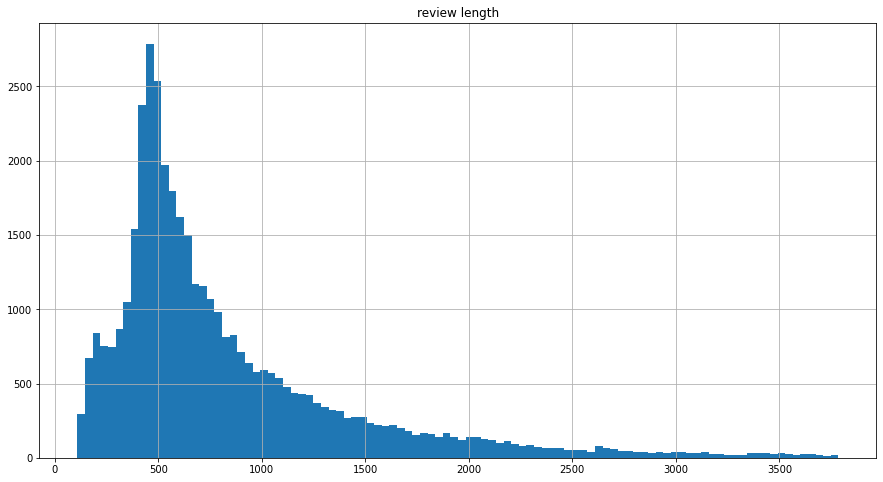

In [12]:
reviews_cnt_df[100:-100].hist(bins=100, figsize=(15, 8))

- Conclusion
    - most of the reviews are around 500 word after ignoring 100 from the left and right

## view words frequencies 
- view most and average and less words freqencies after preprocessing

In [13]:
# get 100 from top and 100 from mid and 100 from tail
src.data_preprocessing.get_head_mid_tail(words_cnt_df,100)

,word,word count
31,movie,66976
73,film,59411
62,his,45522
130,just,28030
129,if,26971
...,...,...
14749,nasal,20
17479,dealbr,20
16001,anthropologist,20
13613,songwriter,20


In [14]:
words_cnt_df.describe()

,word count
count,17943.000000
mean,289.239982
std,1373.175361
min,20.000000
25%,31.000000
50%,56.000000
75%,143.000000
max,66976.000000


# split data to train and test
- load the reviews.txt and labels.txt , a line seprated movie reviews and thier corresponding lables are (`positive`,`negative`) for positive and negative reviews
- split the data to train and test , save them in json file (`train.json`,`test.json`)
- each json file contains dict of two keys `reviews` is a list of the reviews and `labels` is a list of the labels for this reviews

In [15]:
with open(os.path.join(prep_dataset_dir, 'reviews.txt'), 'r') as rev_file:
    prep_reviews_txt = rev_file.read()
with open(os.path.join(prep_dataset_dir, 'labels.txt'), 'r') as labels_file:
    prep_labels_txt = labels_file.read()

## train data test split

In [16]:
from sklearn.model_selection import train_test_split
all_reviews=prep_reviews_txt.split('\n')
all_labels=prep_labels_txt.split('\n')
non_zero_labels=[]
non_zero_rev_list=[]
for i in range(len(all_reviews)):
  if len(all_reviews[i])>2:
    non_zero_rev_list.append(all_reviews[i])
    non_zero_labels.append(all_labels[i])

all_reviews=non_zero_rev_list
all_labels=non_zero_labels
print(f"no reviews {len(all_reviews)}")
print(f"no labels {len(all_labels)}")

train_reviews,test_reviews,train_labels,test_labels=train_test_split(all_reviews,all_labels,test_size=0.2)
# train_reviews,valid_reviews,train_labels,valid_labels=train_test_split(train_reviews,train_labels,test_size=0.2)

print(f"train size {len(train_reviews)}")
# print(f"valid size {len(valid_reviews)}")
print(f"test size {len(test_reviews)}")

no reviews 40000
no labels 40000
train size 32000
test size 8000


In [17]:
# save train data and test data in json file 

train_data_dict={"reviews":train_reviews,"labels":train_labels}
test_data_dict={"reviews":test_reviews,"labels":test_labels}

src.utils.save_json(train_data_dict,os.path.join(prep_dataset_dir,"train.json"))
src.utils.save_json(test_data_dict,os.path.join(prep_dataset_dir,"test.json"))

# Train Data Loader
- the train loader specifies a fixed length for a review and this will be the LSTM model sequence length
- train loader will pad short reviews with zeros from left and trim large reviews from right
- the shape of the input will be (batch_size,sequence_size(review length),1 (intValue for the word))

In [3]:
os.listdir(prep_dataset_dir)

['labels.txt',
 'reviews.txt',
 'sentiment_analysis',
 'skipgram',
 'test.json',
 'train.json',
 'word2int.json']

In [4]:
word2int=src.utils.load_json(os.path.join(prep_dataset_dir,"word2int.json"))


In [5]:
print(f"int value for amazing {word2int['amazing']}")
print(f"int value for good {word2int['good']}")

print(f"int value for ridiculous {word2int['ridiculous']}")
print(f"int value for bad {word2int['bad']}")

int value for amazing 444
int value for good 6
int value for ridiculous 603
int value for bad 39


In [6]:
train_data=src.load_json(os.path.join(prep_dataset_dir,"train.json"))
# valid_data=src.load_json(os.path.join(prep_dataset_dir,"valid.json"))
test_data=src.load_json(os.path.join(prep_dataset_dir,"test.json"))


In [7]:
import torch
def_review_len=500
batch_size=512
device="cuda" if torch.cuda.is_available() else "cpu"

In [8]:
train_dataloader=src.SentimentAnalysisDataset(train_data['reviews'],train_data['labels'],word2int=word2int,batch_size=batch_size,def_review_len=def_review_len)
# valid_dataloader=src.SentimentAnalysisDataset(valid_data['reviews'],valid_data['labels'],word2int=word2int,batch_size=batch_size,def_review_len=def_review_len)
test_dataloader=src.SentimentAnalysisDataset(test_data['reviews'],test_data['labels'],word2int=word2int,batch_size=batch_size,def_review_len=def_review_len)

In [9]:
print(len(train_dataloader.int_rev_list))

32000


# Sentiment analysis model
- the model takes a review of a fixed length (sequence length) as input and hidden (short term and long term output for the last word in the review ) outputs of the lstm layer
- embedding layer outputs the vector representation for each word with embedding size as input-size for LSTM (bach_size,seq_length,embedding_dimension)
- output for the sequence of words discarded except the output for the last word which is taken as the review output <br><br>
- example for a review length =5 and batch dimension is ignored <br><br>
- ![forward_img](./assets/model_forward.JPG)

In [ ]:
# load embbeded from Skipgram model
skip_gram_model=src.SkipGram(vocab_size=len(word2int),embedding_size=256).to(device)
last_weights=traintracker.latest_weights_path(skip_gram_weights)
print(last_weights)
state_dict=torch.load(traintracker.latest_weights_path(skip_gram_weights))

skip_gram_model.load_state_dict(state_dict)

sentiment_model=src.SentimentAnalysis(word2int=word2int,embedding_dim=256,n_layers=2,hidden_nodes=256,embedding_layer=skip_gram_model.input_embedding).to(device)
skip_gram_model=None

In [11]:
# load model from saved weights

sentiment_model=src.SentimentAnalysis(word2int=word2int,embedding_dim=256,n_layers=2,hidden_nodes=256,dropout_prop=0.6).to(device)
latest_weights=traintracker.latest_weights_path(weights_dir)
state_dict=torch.load(latest_weights,map_location='cpu')
sentiment_model.load_state_dict(state_dict)

<All keys matched successfully>

# Model training
- train method exists in [model_training.py](../src/model_training.py)
- the model first load the embedding layer from the skip-gram model
- then the training starts with freezing the embedding layer and leaving the LSTM and fc to train for about 20 epochs to get the right weights without updating the embedding layer with learning rate 0.001
- then the model trained for another 20 epochs after un-freezing the embedding to make it tailored for the sentiment analysis with small learning rate 0.0001
- the model reached accuracy about 90%

In [31]:
import src.model_training as train
reload(train)

<module 'src.model_training' from 'D:\\2022 acheivments\\Projects\\DeepLearning NanoDegree\\sentiment-analysis-RNN\\src\\model_training.py'>

In [ ]:
# sentiment_model.lstm.requires_grad_(requires_grad=False)
from torch import optim
sentiment_model.embedding_layer.requires_grad_(requires_grad=False)
optimizer=optim.Adam(sentiment_model.parameters(),lr=0.001)

In [ ]:
latest_weights=traintracker.latest_weights_path(weights_dir)
print(latest_weights)

state_dict=torch.load("/content/drive/MyDrive/projects/sentiment-analysis-RNN/model_weights/sentiment_analysis/12_07 15_41 Train_(0.175) Test_(0.24458).pt")
sentiment_model.load_state_dict(state_dict)

/content/drive/MyDrive/projects/sentiment-analysis-RNN/model_weights/sentiment_analysis/last_weights.pt


<All keys matched successfully>

In [ ]:
train.sentiment_model_train(sentiment_model,20,train_dataloader,test_dataloader,notes="start with skip-gram 2.83 noise 10 window 4",weights_dir=weights_dir,train_data_dir=train_data_dir,device=device,optimizer=optimizer)

In [ ]:
state_dict=torch.load(traintracker.latest_weights_path(weights_dir))
sentiment_model.load_state_dict(state_dict)

In [ ]:
sentiment_model.embedding_layer.requires_grad_(requires_grad=True)
train.sentiment_model_train(sentiment_model,1,train_dataloader,test_dataloader,notes="un freeze embbding layer",weights_dir=weights_dir,train_data_dir=train_data_dir,device=device,optimizer=optimizer)

In [ ]:
latest_weights=traintracker.latest_weights_path(weights_dir)
state_dict=torch.load(latest_weights)
sentiment_model.load_state_dict(state_dict)

In [78]:
hyperparameters_hist=pd.read_csv(train_data_dir+'/train_data.csv')
epochs_hist=pd.read_csv(train_data_dir+'/epochs_data.csv')

In [79]:
hyperparameters_hist.head()

,epoch idx from,model architecture,batch_size,optimizer,review length,grad clip,notes,changed hyperParameters
0,1,SentimentAnalysis(\n (embedding_layer): Embed...,256,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,start with skip-gram 3.43 noise 20 window 4,"['model architecture', 'batch_size', 'optimize..."
1,9,SentimentAnalysis(\n (embedding_layer): Embed...,256,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,start with skip-gram 3.43 noise 20 window 4,['model architecture']
2,13,SentimentAnalysis(\n (embedding_layer): Embed...,256,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,start with skip-gram 3.43 noise 20 window 4,['model architecture']
3,19,SentimentAnalysis(\n (embedding_layer): Embed...,256,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,start with skip-gram 3.43 noise 20 window 4,['model architecture']
4,27,SentimentAnalysis(\n (embedding_layer): Embed...,256,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,start with skip-gram 3.43 noise 20 window 4,['model architecture']


In [80]:
epochs_hist.head()

,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Date,Time
0,0.558425,32000,0.343062,7936,1.36,6/12/2022,12:11:00
1,0.323052,32000,0.310125,7936,1.33,6/12/2022,12:12:00
2,0.297753,32000,0.302829,7936,1.38,6/12/2022,12:12:00
3,0.295758,32000,0.319415,7936,1.38,6/12/2022,12:13:00
4,0.285818,32000,0.294930,7936,1.38,6/12/2022,12:14:00


- the best result came with the last 4 intervals of training after training skip-gram model with 256 embedding dimension and remove text that doesn't affect the review context
- starting with skip-gram model with loss 2.84 with window size around  word 4 and noise output size for each word 10 words
- the model first trained 20 epochs with freezing the embedding layer and then the full model trained  6 epochs with a learning rate decreased from 0.001 to 0.0001

In [81]:
hyperparameters_hist[-3:]

,epoch idx from,model architecture,batch_size,optimizer,review length,grad clip,notes,changed hyperParameters
20,156,SentimentAnalysis(\n (embedding_layer): Embed...,512,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,start with skip-gram 2.84 noise 10 window 4,"['model architecture', 'notes']"
21,176,SentimentAnalysis(\n (embedding_layer): Embed...,512,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,un freeze embbding layer,['notes']
22,177,SentimentAnalysis(\n (embedding_layer): Embed...,512,Adam (\nParameter Group 0\n amsgrad: False\...,500,5,un freeze embbding layer,['optimizer']


In [82]:
epochs_hist[156:]

,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Date,Time
156,0.407674,31744,0.399347,7680,1.30,7/12/2022,15:22:00
157,0.379864,31744,0.374632,7680,1.34,7/12/2022,15:23:00
158,0.380238,31744,0.379936,7680,1.30,7/12/2022,15:23:00
159,0.343455,31744,0.317049,7680,1.32,7/12/2022,15:24:00
160,0.322637,31744,0.330400,7680,1.32,7/12/2022,15:25:00
161,0.328207,31744,0.306236,7680,1.32,7/12/2022,15:25:00
162,0.281549,31744,0.288165,7680,1.34,7/12/2022,15:26:00
163,0.269618,31744,0.297496,7680,1.34,7/12/2022,15:27:00
164,0.284772,31744,0.307462,7680,1.34,7/12/2022,15:27:00
165,0.290681,31744,0.293288,7680,1.34,7/12/2022,15:28:00


<AxesSubplot:>

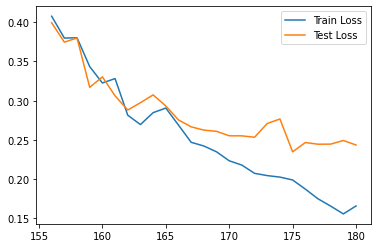

In [83]:
epochs_hist[156:].plot(y=['Train Loss','Test Loss'])

# Model perfromance

In [19]:
threshold=0.50
sentiment_model.eval()
actual_values=[]
predicted_values=[]
with torch.no_grad():
  hidden=None
  for batch_x,actual_out in test_dataloader:

    actual_values.extend(torch.flatten(actual_out==1).tolist())

    batch_x, actual_out = batch_x.to(device), actual_out.to(device)

    # shape --> (batch_size,1)


    pred_out,hidden=sentiment_model(batch_x,hidden)

    pred_out=pred_out>threshold

    predicted_values.extend(torch.flatten(pred_out).to('cpu').tolist())



In [31]:
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,accuracy_score

conf_matrix=confusion_matrix(actual_values,predicted_values)
model_score_list=[['accuracy_score',accuracy_score(actual_values,predicted_values)],
                  ['recall_score',recall_score(actual_values,predicted_values)],
                  ['precision_score',precision_score(actual_values,predicted_values)],
                  ['f1_score',f1_score(actual_values,predicted_values)]
                  ]
model_score_df=pd.DataFrame(model_score_list,columns=['metric','score'])

conf_matrix_df=pd.DataFrame(conf_matrix,index=['Actual (P)','Actual (N)'],columns=['Predicted (P)','Predicted (N)'])



In [28]:
conf_matrix_df

,Actual (P),Actual (N)
Predicted (P),3434,353
Predicted (N),297,3596


In [32]:
model_score_df

,metric,score
0,accuracy_score,0.915365
1,recall_score,0.923709
2,precision_score,0.910610
3,f1_score,0.917113


# Model usage

In [7]:
from src import sentiment_analyisis
import random


# load model for prediction first
sentiment_analyisis.load_model()
threshold=0.5
n_samples=5

In [8]:
import os
# load raw not preprocessed reviews
with open(os.path.join(raw_dataset_dir, 'reviews.txt'), 'r',encoding='utf-8') as rev_file:
    raw_reviews_txt = rev_file.read()
with open(os.path.join(raw_dataset_dir, 'labels.txt'), 'r',encoding='utf-8') as labels_file:
    raw_labels_txt = labels_file.read()


reviews_list = raw_reviews_txt.split('\n')
labels_list = raw_labels_txt.split('\n')

In [9]:
for i in range(n_samples):
    rand_rev_idx=random.randint(0,len(reviews_list))

    print(reviews_list[rand_rev_idx])
    print()
    print(f"actual label:{labels_list[rand_rev_idx]}")

    predicted_probability=sentiment_analyisis.predict(reviews_list[rand_rev_idx])

    print(f"predicted probability:{predicted_probability}")
    print(f"predicted label:{'positive' if predicted_probability>=threshold else 'negative'}")
    print()

This is one of those movies that's difficult to review without giving away the plot. Suffice to say there are weird things and unexpected twists going on, beyond the initial superficial "Tom Cruise screws around with multiple women" plot.<br /><br />The quality cast elevate this movie above the norm, and all the cast are well suited to their parts: Cruise as the irritatingly smug playboy who has it all - and then loses it all, Diaz as the attractive but slightly deranged jilted lover, Cruz as the exotic new girl on the scene and Russell as the fatherly psychologist. The story involves elements of romance, morality, murder-mystery, suspense and sci-fi and is generally an entertaining trip.<br /><br />I should add that the photography is also uniformly excellent and the insertion of various visual metaphors is beautiful once you realize what's going on.<br /><br />If you enjoy well-acted movies with twists and suspense, and are prepared to accept a slightly fantastic Philip K Dick style 